# Representing image using matching pursuit (MP) with Gaussian basis functions

This notebook uses a variant of the matching pusuit algorithm (Elad, 2014) to decompose a frame from a microscopy video into a weighted sum of Gaussian basis functions.

In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
import h5py
import dpmeans
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from skimage.util import img_as_float, img_as_uint
from scipy import ndimage
from scipy.stats import multivariate_normal

from otimage import io 
from otimage.imagerep import greedy_mp

### Parameters

In [3]:
# Relative threshold applied to image
THRESHOLD_REL = 0.15

# Minimum number of pixels for component to be considered
CELL_MIN_SIZE = 50

### Load Zimmer data

In [4]:
# Path to file containing Zimmer data
in_fpath = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'

# Index of frame to use
t_frame = 25

with io.ZimmerReader(in_fpath) as reader:
    frame = reader.get_frame(t_frame)

### Select section of frame for test image

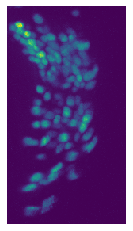

In [8]:
# Section of XY plane where head is found
head_x = (500, 650)
head_y = (250, 525)
head_z = (0, 33)

# Extract section
img = frame[head_x[0]:head_x[1], head_y[0]:head_y[1], head_z[0]:head_z[1]]
img = img_as_float(img)

# Compute image min and max
img_min = np.min(img)
img_max = np.max(img)

# Display max projection
plt.imshow(np.max(img, 2).T);
plt.axis('off');

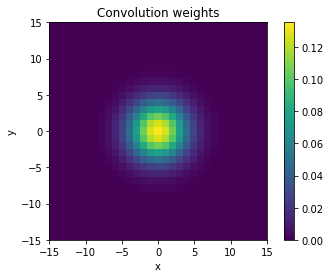

In [6]:
wx = 15
wy = 15
wz = 5
xg, yg, zg = np.mgrid[-wx:wx+1, -wy:wy+1, -wz:wz+1]
weight_grid = np.stack((xg, yg, zg), axis=-1)

mean = np.array([0, 0, 0]) 
cov = np.diag([8.0, 8.0, 1.5])
weights_nn = multivariate_normal.pdf(weight_grid, mean=mean, cov=cov)
weights = weights_nn / np.sqrt(np.sum(weights_nn ** 2))

plt.imshow(np.max(weights, 2).T, origin='lower', extent=[-15, 15, -15, 15])
plt.title('Convolution weights')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar();

In [7]:
%%time
pts, vals, img_conv = greedy_mp(img, weights, 1)

CPU times: user 25.4 s, sys: 527 ms, total: 25.9 s
Wall time: 25.8 s


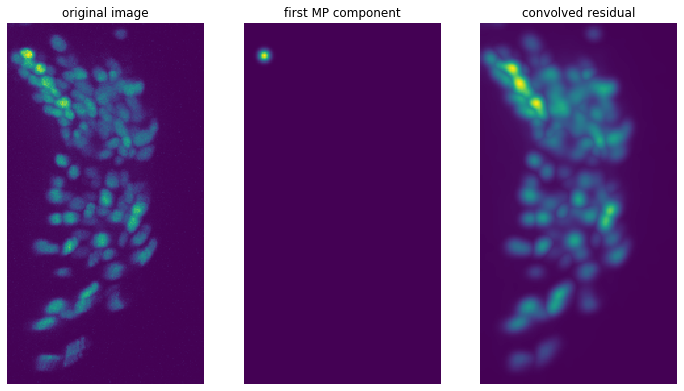

In [8]:
img_rep = np.zeros((img.shape[0] + 2 * wx, img.shape[1] + 2 * wy, img.shape[2] + 2 * wz))

pt = pts[0]
pt_mod = pt + np.array([wx, wy, wz])
x_sl = slice(pt_mod[0] - wx, pt_mod[0] + wx + 1)
y_sl = slice(pt_mod[1] - wy, pt_mod[1] + wy + 1)
z_sl = slice(pt_mod[2] - wz, pt_mod[2] + wz + 1)
img_rep[x_sl, y_sl, z_sl] = vals[0] * weights
img_rep = img_rep[wx:-wx, wy:-wy, wz:-wz]

plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.imshow(np.max(img, 2).T);
plt.axis('off');
plt.title('original image')

plt.subplot(132)
plt.imshow(np.max(img_rep, 2).T)
plt.axis('off')
plt.title('first MP component');

plt.subplot(133)
plt.imshow(np.max(img_conv, 2).T)
plt.axis('off')
plt.title('convolved residual');

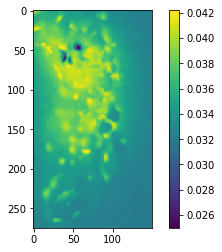

In [9]:
points, vals, img_conv = greedy_mp(img, weights, 300)

plt.imshow(np.max(img_conv, 2).T)
plt.colorbar()

In [10]:
recon_img = np.zeros((img.shape[0] + 2 * wx, img.shape[1] + 2 * wy, img.shape[2] + 2 * wz))
points_mod = points + np.array([wx, wy, wz])

for i in range(points_mod.shape[0]):
    
    pt = points_mod[i]
    x_sl = slice(pt[0] - wx, pt[0] + wx + 1)
    y_sl = slice(pt[1] - wy, pt[1] + wy + 1)
    z_sl = slice(pt[2] - wz, pt[2] + wz + 1)
    
    recon_img[x_sl, y_sl, z_sl] += vals[i] * weights
    
r_img = recon_img[wx:-wx, wy:-wy, wz:-wz]


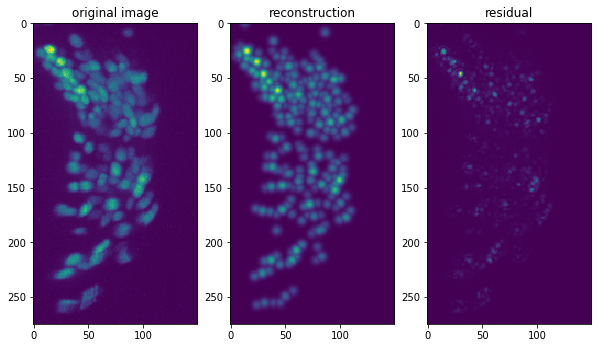

In [11]:
plt.figure(figsize=(10, 10))

plt.subplot(131)
plt.imshow(np.max(img, 2).T)
plt.title('original image')

plt.subplot(132)
plt.imshow(np.max(r_img, 2).T)
plt.title('reconstruction')

sq_res_img = (r_img - img) ** 2
plt.subplot(133)
plt.imshow(np.max(sq_res_img, 2).T)
plt.title('residual')

plt.savefig('greedy_mp_1.png')